# rio-tiler.mosaic



In This notebook you'll learn how to:
- use create mercator tiles from multiple observations (assets) using `rio_tiler.mosaic` submodule
- create custom `pixel_selection` methods
- look for sentinel-2-cogs data
- create custom tiler using `STACReade``

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Requirements

To be able to run this notebook you'll need the following requirements:
- rasterio
- ipyleaflet
- rio-tiler~= 2.0b

In [ ]:
!pip install rio-tiler ipyleaflet --pre rio-tiler

In [2]:
import json
import requests

import mercantile

from rio_tiler.io import COGReader, STACReader

from rio_tiler.mosaic import mosaic_reader
from rio_tiler.mosaic.methods import defaults

from rio_tiler.mosaic.methods.base import MosaicMethodBase

from rio_tiler.utils import linear_rescale
from rio_tiler.colormap import get_colormap
from rio_tiler.profiles import img_profiles

from rasterio.plot import reshape_as_image
from rasterio.features import bounds as featureBounds

from ipyleaflet import Map, basemaps, TileLayer, basemap_to_tiles, GeoJSON

## Data

For this demo we will use the Sentinel-2 data stored as COGs on AWS.

### Sentinel 2 COGs
Thanks to Digital Earth Africa and in collaboration with Sinergise, Element 84, Amazon Web Services (AWS) and the Committee on Earth Observation Satellites (CEOS), Sentinel 2 (Level 2) data over Africa, usually stored as JPEG2000, has been translated to COG more important a STAC database and API has been setup.

https://www.digitalearthafrica.org/news/operational-and-ready-use-satellite-data-now-available-across-africa

The API is provided by @element84 and follows the latest specification: https://earth-search.aws.element84.com/v0

In [3]:
stac_endpoint = "https://earth-search.aws.element84.com/v0/search"

### Search for data

#### Define Area of Interest (AOI)

In [4]:
# use geojson.io
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              30.810813903808594,
              29.454247067148533
            ],
            [
              30.88600158691406,
              29.454247067148533
            ],
            [
              30.88600158691406,
              29.51879923863822
            ],
            [
              30.810813903808594,
              29.51879923863822
            ],
            [
              30.810813903808594,
              29.454247067148533
            ]
          ]
        ]
      }
    }
  ]
}

bounds = featureBounds(geojson)

### STAC Search

Use STAC API to search for data over our AOI

Doc: https://github.com/radiantearth/stac-api-spec

In [5]:
# Date filter
date_min="2019-06-01"
date_max="2019-09-01"

start = datetime.datetime.strptime(date_min, "%Y-%m-%d").strftime("%Y-%m-%dT00:00:00Z")
end = datetime.datetime.strptime(date_max, "%Y-%m-%d").strftime("%Y-%m-%dT23:59:59Z")

query = {
    "collections": ["sentinel-s2-l2a-cogs"], # Make sure to query only sentinel-2 COGs collection
    "datetime": f"{start}/{end}",
    "query": {
        "eo:cloud_cover": {
            "lt": 5
        }  # Use low cloud cover
    },
    "intersects": geojson["features"][0]["geometry"],
    "limit": 1000,
    "fields": {
      'include': ['id', 'properties.datetime', 'properties.eo:cloud_cover'],  # Make returned response ligth 
      'exclude': ['links']
    }
}

headers = {
    "Content-Type": "application/json",
    "Accept-Encoding": "gzip",
    "Accept": "application/geo+json",
}


data = requests.post(stac_endpoint, headers=headers, json=query).json()
print(data["context"])
print()
print("Example:")
print(json.dumps(data["features"][0], indent=4))

sceneid = [f["id"] for f in data["features"]]
cloudcover = [f["properties"]["eo:cloud_cover"] for f in data["features"]]
dates = [f["properties"]["datetime"][0:10] for f in data["features"]]

# For this demo we will use the True color image `TCI` asset
assets = [f["assets"]["visual"]["href"] for f in data["features"]]

{'page': 1, 'limit': 1000, 'matched': 21, 'returned': 21}

Example:
{
    "assets": {
        "overview": {
            "proj:shape": [
                343,
                343
            ],
            "proj:transform": [
                320,
                0,
                199980,
                0,
                -320,
                3300000,
                0,
                0,
                1
            ],
            "href": "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2B_36RTT_20190830_0_L2A/L2A_PVI.tif",
            "title": "True color image",
            "type": "image/tiff; application=geotiff; profile=cloud-optimized"
        },
        "thumbnail": {
            "href": "https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/36/R/TT/2019/8/30/0/preview.jpg",
            "title": "Thumbnail",
            "type": "image/png"
        },
        "metadata": {
            "href": "https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/36/R/TT

In [6]:
m = Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    center=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom=8
)

geo_json = GeoJSON(
    data=data,
    style={
        'opacity': 1, 'dashArray': '1', 'fillOpacity': 0, 'weight': 1
    },
)
m.add_layer(geo_json)
m

Map(center=[29.486523152893376, 30.848407745361328], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Define the tiler

In [7]:
def tiler(asset, *args, **kwargs):
    with COGReader(asset) as cog:
        return cog.tile(*args, **kwargs)

In [8]:
# List of z12 mercatile tile
tiles = list(mercantile.tiles(*bounds, 12))

### FirstMethod: Fill with the first value avialable

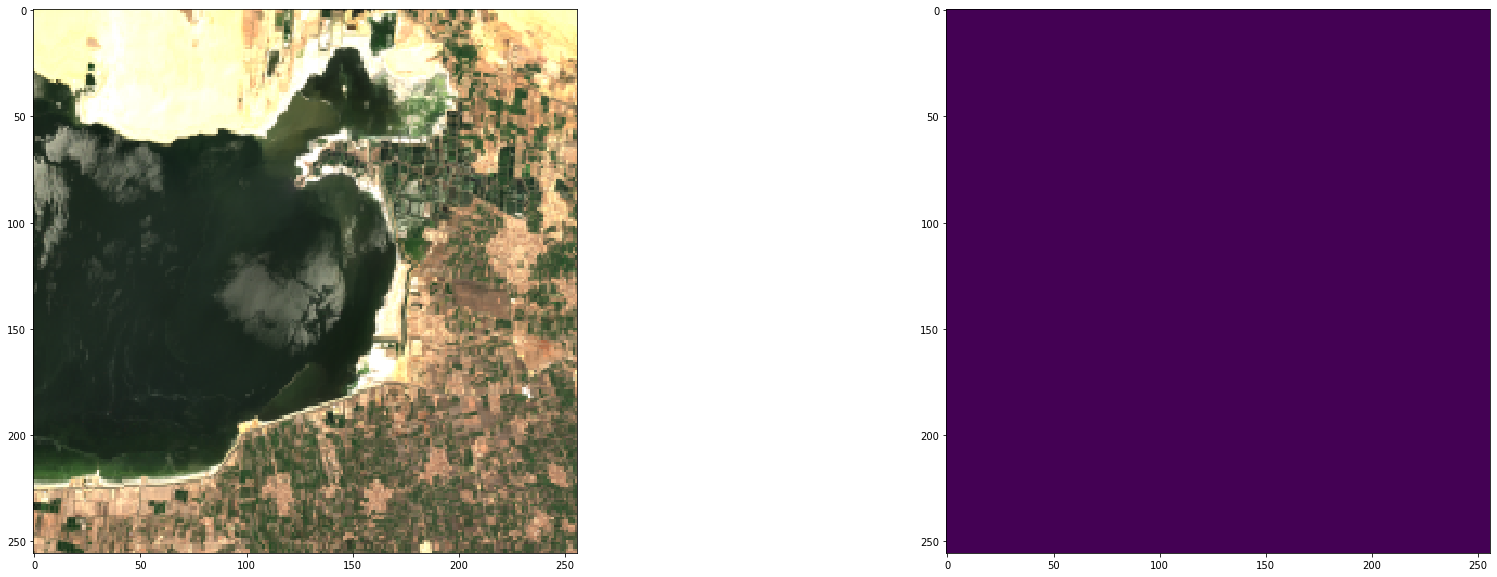

In [9]:
tile = tiles[0]

(tile, mask), assets_used = mosaic_reader(
    assets,
    tiler,
    tile.x,
    tile.y,
    tile.z,
    threads=1,
    chunk_size=2,
)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(reshape_as_image(tile))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)

In [10]:
print(assets_used)

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2B_36RTT_20190830_0_L2A/TCI.tif']


### MeanMethod: Get the mean from all the stack of data

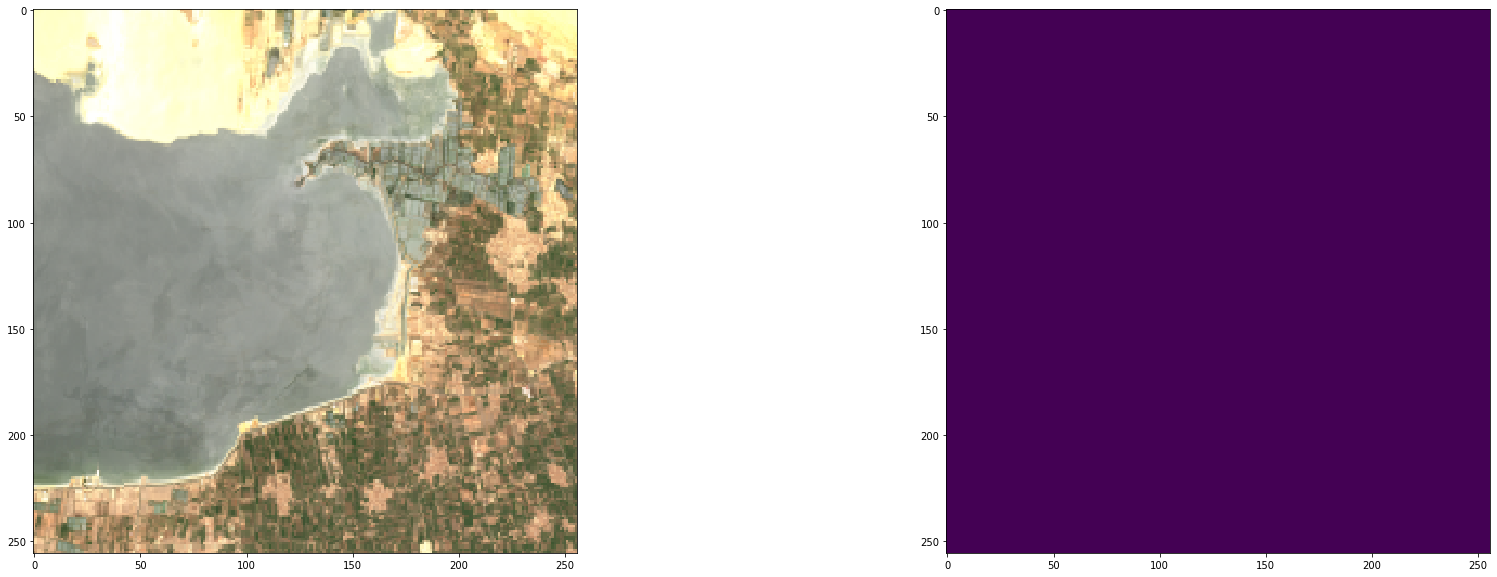

In [11]:
tile = tiles[0]

(tile, mask), assets_used = mosaic_reader(
    assets,
    tiler,
    tile.x,
    tile.y,
    tile.z,
    pixel_selection=defaults.MeanMethod(),
)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(reshape_as_image(tile))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)

In [12]:
print(assets_used)

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2B_36RTT_20190830_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2A_36RTT_20190825_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2B_36RTT_20190820_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2A_36RTT_20190815_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2B_36RTT_20190810_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2A_36RTT_20190805_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2A_36RTT_20190726_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2B_36RTT_20190721_0_L2A/TCI.tif', 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/2019/S2B_36RTT_20190718_0_L2A/TCI.tif', 

## Create Custom pixel_selection class 

### 1. Using a 4th band for decision: highest NDVI  

In [14]:
stac_item = "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/{sceneid}"
stac_assets = [stac_item.format(sceneid=scene) for scene in sceneid]

In [15]:
# Fisrt, let's checkout the STDEV of the NDVI values
# Because we need to use multiple STAC assets, it's easier to use the STACReader
def custom_tiler(asset, *args, **kwargs):
    with STACReader(asset) as stac:
        return stac.tile(*args, expression="(B08-B04)/(B08+B04)")

tile = tiles[0]

(tile, mask), assets_used = mosaic_reader(
    stac_assets,
    custom_tiler,
    tile.x,
    tile.y,
    tile.z,
    pixel_selection=defaults.StdevMethod(),
    threads=1,
    chunk_size=2,
)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(tile[0])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)

In [51]:
# We create a custom tiler function that will read the TCI asset and add a 4th representing the NDVI 
def custom_tiler(asset, *args, **kwargs):
    with STACReader(asset) as stac:
        tile, mask = stac.tile(*args, assets="visual")
        ndvi, _ = stac.tile(*args, expression="(B08-B04)/(B08+B04)")
        return numpy.concatenate((tile, ndvi)), mask

In [37]:
class CustomFourthBandH(MosaicMethodBase):
    """Feed the mosaic tile with the Mean pixel value."""

    @property
    def data(self):
        """Return data and mask."""
        if self.tile is not None:
            return self.tile.data[:-1], ~self.tile.mask[0] * 255
        else:
            return None, None

    def feed(self, tile):
        """Add data to tile."""

        if self.tile is None:
            self.tile = tile
            return

        pidex = (
            numpy.bitwise_and(tile.data[-1] > self.tile.data[-1], ~tile.mask) | self.tile.mask
        )

        mask = numpy.where(pidex, tile.mask, self.tile.mask)
        self.tile = numpy.ma.where(pidex, tile, self.tile)
        self.tile.mask = mask

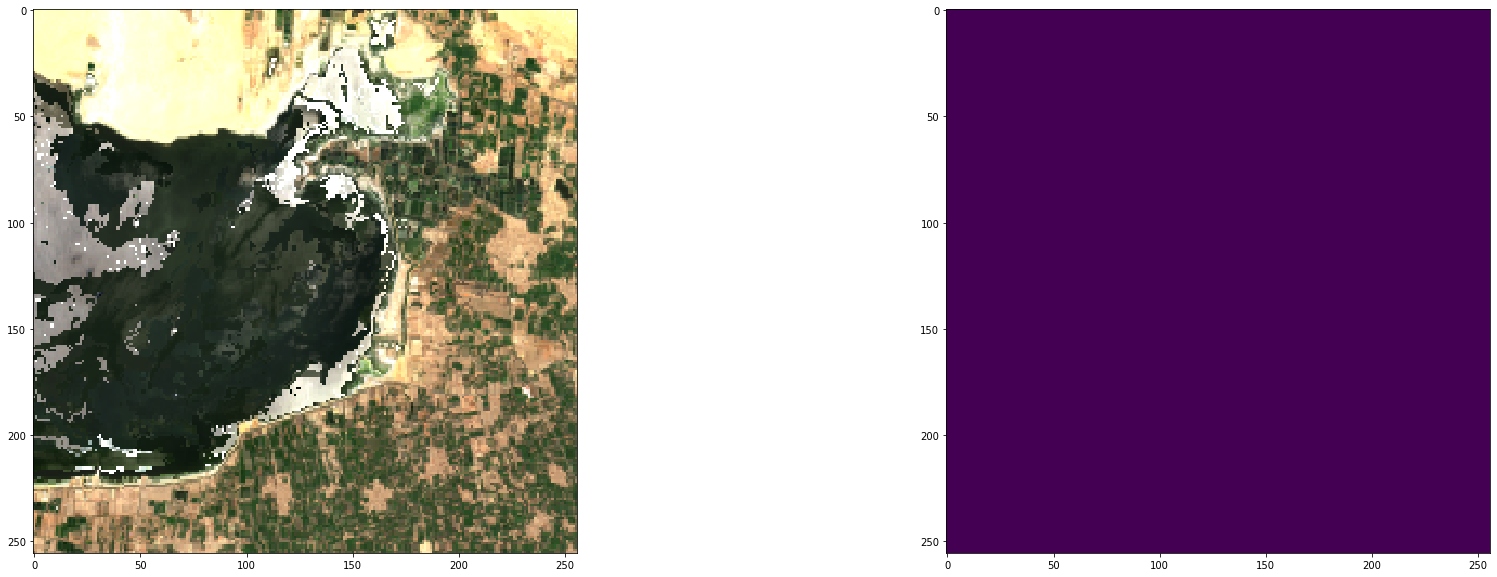

In [57]:
tile = tiles[0]

(tile, mask), assets_used = mosaic_reader(
    stac_assets[0:10],
    custom_tiler,
    tile.x,
    tile.y,
    tile.z,
    pixel_selection=CustomFourthBandH(),
    threads=1,
    chunk_size=2,
)

fig = figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)

# NOTE: because we are using NDVI + Visual, the output array, will be in float32
ax.imshow(reshape_as_image(tile.astype("uint8")))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)